In [1]:
# 1. Install and Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import warnings
from tqdm import tqdm

# Darts
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import rmse, mape
from darts.models import (
    ExponentialSmoothing,
    AutoARIMA,
    Prophet,
    TiDEModel,
    NBEATSModel,
    TFTModel
)

# Suppress warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("darts").setLevel(logging.WARNING)

print("Libraries imported.")

Libraries imported.


In [2]:
# Check availability of specific models
try:
    from darts.models import AutoARIMA
    print("AutoARIMA available.")
except ImportError:
    print("AutoARIMA NOT available.")

try:
    from darts.models import Prophet
    print("Prophet available.")
except ImportError:
    print("Prophet NOT available (install 'prophet' or 'fbprophet').")


AutoARIMA available.
Prophet available.


Full series duration: 1993-12-01 00:00:00 to 2025-12-01 00:00:00
Training set duration: 1993-12-01 00:00:00 to 2023-12-01 00:00:00
Test set duration: 2024-01-01 00:00:00 to 2025-12-01 00:00:00


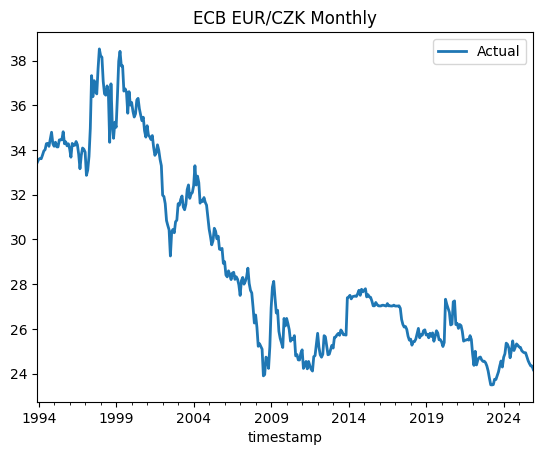

In [3]:
# 2. Load and Preprocess Data

# Load dataset
df = pd.read_csv('../datasets/ecb_eurczk_monthly.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
series = TimeSeries.from_dataframe(df, 'timestamp', 'eur_czk')

# Cast to float32 for MPS/DL compatibility
series = series.astype(np.float32)

# Split Train/Test
# Let's reserve the last 24 months for testing
train, test = series.split_after(pd.Timestamp(series.end_time()) - pd.DateOffset(months=24))

# Scaler for DL models
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
series_scaled = scaler.transform(series)

print(f"Full series duration: {series.start_time()} to {series.end_time()}")
print(f"Training set duration: {train.start_time()} to {train.end_time()}")
print(f"Test set duration: {test.start_time()} to {test.end_time()}")

series.plot(label='Actual')
plt.title('ECB EUR/CZK Monthly')
plt.show()

In [4]:
# 3. Define Evaluation Metrics and Logging

results = []

def log_result(model_name, rmse_val, mape_val, training_time, params=None):
    results.append({
        'Model': model_name,
        'RMSE': rmse_val,
        'MAPE': mape_val,
        'Time (s)': training_time,
        'Params': params
    })
    print(f"Logged: {model_name} | RMSE: {rmse_val:.4f} | MAPE: {mape_val:.2f}% | Time: {training_time:.2f}s")

def get_results_df():
    return pd.DataFrame(results).sort_values(by='RMSE')

In [5]:
# 4. Define Hyperparameter Tuning Strategy (Random Search) & Cross Validation

def random_grid_search(model_cls, param_grid, n_iter=5):
    """
    Generates a list of random parameter combinations from the grid.
    """
    keys = list(param_grid.keys())
    combinations = []
    
    if not keys:
        return [{}]

    # Generate all combinations (if small) or sample
    # For simplicity, we'll just sample n_iter times
    for _ in range(n_iter):
        params = {}
        for key in keys:
            params[key] = random.choice(param_grid[key])
        combinations.append(params)
    
    # Remove duplicates
    unique_combinations = [dict(t) for t in {tuple(d.items()) for d in combinations}]
    return unique_combinations

def evaluate_model(model_cls, params, series_train, series_val, is_dl=False, forecast_horizon=12, stride=1, scaler=None, original_series=None):
    """
    Evaluates a model using rolling window cross-validation (historical_forecasts).
    """
    start_time = time.time()
    
    try:
        model = model_cls(**params)
        
        if is_dl:
            # DL models need fit on series
            model.fit(series_train, verbose=False)
            # Retraining=False for DL to save time
            backtest_series = model.historical_forecasts(
                series=series_train,
                start=0.7,
                forecast_horizon=forecast_horizon,
                stride=stride,
                retrain=False,
                verbose=False,
                last_points_only=True
            )
        else:
            # Statistical models
            # Use retrain=True for proper CV without leakage if not fitted
            backtest_series = model.historical_forecasts(
                series=series_train,
                start=0.7,
                forecast_horizon=forecast_horizon,
                stride=stride,
                retrain=True, 
                verbose=False,
                last_points_only=True
            )
            
        # Inverse transform if scaler provided
        if scaler:
            backtest_series = scaler.inverse_transform(backtest_series)
            # We need to compare against original series
            # If original_series is not provided, we assume series_train was scaled and we need to inverse it too
            # But series_train might be the full training set.
            # It's better to use original_series if available.
            if original_series:
                actual_series = original_series
            else:
                actual_series = scaler.inverse_transform(series_train)
        else:
            actual_series = series_train

        # Calculate metrics
        # Darts metrics automatically align the series by time index
        rmse_score = rmse(actual_series, backtest_series)
        mape_score = mape(actual_series, backtest_series)
        
        end_time = time.time()
        return rmse_score, mape_score, end_time - start_time
        
    except Exception as e:
        # Handle NotImportedModule or other errors
        try:
            model_name = model_cls.__name__
        except:
            model_name = str(model_cls)
            
        print(f"Error evaluating {model_name} with params {params}: {e}")
        return float('inf'), float('inf'), 0

def run_tuning_and_eval(model_name, model_cls, param_grid, train_series, is_dl=False, n_iter=5, scaler=None, original_series=None):
    print(f"--- Tuning {model_name} ---")
    
    if not param_grid:
        # No tuning, just run default
        best_params = {}
        rmse_val, mape_val, duration = evaluate_model(model_cls, {}, train_series, None, is_dl=is_dl, scaler=scaler, original_series=original_series)
        if rmse_val != float('inf'):
            log_result(model_name, rmse_val, mape_val, duration, best_params)
        return
        
    combinations = random_grid_search(model_cls, param_grid, n_iter=n_iter)
    
    best_rmse = float('inf')
    best_params = None
    best_metrics = (float('inf'), float('inf'), 0)
    
    for params in tqdm(combinations, desc=f"Tuning {model_name}"):
        rmse_val, mape_val, duration = evaluate_model(model_cls, params, train_series, None, is_dl=is_dl, scaler=scaler, original_series=original_series)
        
        if rmse_val < best_rmse:
            best_rmse = rmse_val
            best_params = params
            best_metrics = (rmse_val, mape_val, duration)
            
    # Log best result
    if best_params is not None and best_rmse != float('inf'):
        log_result(model_name, best_metrics[0], best_metrics[1], best_metrics[2], best_params)
    else:
        print(f"No successful run for {model_name}")
    return best_params

In [6]:
# 5. Train and Evaluate Darts Statistical Models
from darts.utils.utils import ModelMode

# Holt-Winters (ExponentialSmoothing)
# Using ModelMode enums to avoid 'str' object has no attribute 'value' error
hw_grid = {
    'seasonal_periods': [12],
    'trend': [ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE, ModelMode.NONE],
    'seasonal': [ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE, ModelMode.NONE],
    'damped': [True, False]
}

run_tuning_and_eval("Holt-Winters", ExponentialSmoothing, hw_grid, train, is_dl=False, n_iter=5)

# AutoARIMA
# Check if available
try:
    # Try to instantiate to see if it works
    AutoARIMA()
    arima_available = True
except:
    print("AutoARIMA not available (likely missing statsforecast or pmdarima). Skipping.")
    arima_available = False

if arima_available:
    arima_grid = {} 
    run_tuning_and_eval("AutoARIMA", AutoARIMA, arima_grid, train, is_dl=False, n_iter=1)

# Prophet
try:
    Prophet()
    prophet_available = True
except:
    print("Prophet not available. Skipping.")
    prophet_available = False

if prophet_available:
    prophet_grid = {
        'seasonality_mode': ['additive', 'multiplicative'],
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5]
    }
    run_tuning_and_eval("Prophet", Prophet, prophet_grid, train, is_dl=False, n_iter=5)

--- Tuning Holt-Winters ---


Tuning Holt-Winters:  40%|████      | 2/5 [00:07<00:11,  3.68s/it]

Error evaluating ExponentialSmoothing with params {'seasonal_periods': 12, 'trend': <ModelMode.NONE: None>, 'seasonal': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'damped': True}: Can only dampen the trend component
Error evaluating ExponentialSmoothing with params {'seasonal_periods': 12, 'trend': <ModelMode.NONE: None>, 'seasonal': <ModelMode.NONE: None>, 'damped': True}: Can only dampen the trend component


Tuning Holt-Winters: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


Logged: Holt-Winters | RMSE: 0.8136 | MAPE: 2.56% | Time: 3.67s
--- Tuning AutoARIMA ---
Logged: AutoARIMA | RMSE: 0.8981 | MAPE: 2.87% | Time: 3.82s
--- Tuning Prophet ---


Tuning Prophet:   0%|          | 0/3 [00:00<?, ?it/s]22:49:01 - cmdstanpy - INFO - Chain [1] start processing
22:49:01 - cmdstanpy - INFO - Chain [1] done processing
22:49:01 - cmdstanpy - INFO - Chain [1] start processing
22:49:01 - cmdstanpy - INFO - Chain [1] done processing
22:49:01 - cmdstanpy - INFO - Chain [1] start processing
22:49:01 - cmdstanpy - INFO - Chain [1] done processing
22:49:01 - cmdstanpy - INFO - Chain [1] start processing
22:49:02 - cmdstanpy - INFO - Chain [1] done processing
22:49:02 - cmdstanpy - INFO - Chain [1] start processing
22:49:02 - cmdstanpy - INFO - Chain [1] done processing
22:49:02 - cmdstanpy - INFO - Chain [1] start processing
22:49:02 - cmdstanpy - INFO - Chain [1] done processing
22:49:02 - cmdstanpy - INFO - Chain [1] start processing
22:49:02 - cmdstanpy - INFO - Chain [1] done processing
22:49:02 - cmdstanpy - INFO - Chain [1] start processing
22:49:02 - cmdstanpy - INFO - Chain [1] done processing
22:49:02 - cmdstanpy - INFO - Chain [1] sta

Logged: Prophet | RMSE: 1.2964 | MAPE: 3.86% | Time: 5.09s


In [7]:
# 6. Train and Evaluate Darts Deep Learning Models
# These require scaled data

common_dl_params = {
    'input_chunk_length': [12, 24],
    'output_chunk_length': [1, 6, 12],
    'n_epochs': [10, 20], # Low for demo/skeleton speed
    'random_state': [42]
}

# TiDE
tide_grid = {
    **common_dl_params,
    'hidden_size': [64, 128],
    'dropout': [0.1, 0.2],
    'num_encoder_layers': [1, 2],
    'num_decoder_layers': [1, 2]
}
run_tuning_and_eval("TiDE", TiDEModel, tide_grid, train_scaled, is_dl=True, n_iter=3, scaler=scaler, original_series=train)

# N-BEATS
nbeats_grid = {
    **common_dl_params,
    'num_stacks': [10, 20],
    'num_blocks': [1, 2],
    'layer_widths': [128, 256]
}
run_tuning_and_eval("N-BEATS", NBEATSModel, nbeats_grid, train_scaled, is_dl=True, n_iter=3, scaler=scaler, original_series=train)

# TFT (Temporal Fusion Transformer)
tft_grid = {
    **common_dl_params,
    'hidden_size': [16, 32], # TFT is heavy
    'lstm_layers': [1],
    'num_attention_heads': [4],
    'dropout': [0.1]
}
# TFT requires future covariates if output_chunk_length > 0 usually, or just works on series.
# Darts TFT might need add_relative_index=True if no covariates provided.
tft_grid['add_relative_index'] = [True]

run_tuning_and_eval("TFT", TFTModel, tft_grid, train_scaled, is_dl=True, n_iter=2, scaler=scaler, original_series=train)

--- Tuning TiDE ---


Tuning TiDE:   0%|          | 0/3 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Tuning TiDE:  33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Tuning TiDE:  67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Logged: TiDE | RMSE: 0.7818 | MAPE: 2.56% | Time: 0.56s
--- Tuning N-BEATS ---


Tuning N-BEATS:   0%|          | 0/3 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Tuning N-BEATS:  33%|███▎      | 1/3 [00:06<00:13,  6.82s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Tuning N-BEATS:  67%|██████▋   | 2/3 [00:10<00:05,  5.08s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using

Logged: N-BEATS | RMSE: 0.9420 | MAPE: 2.93% | Time: 7.30s
--- Tuning TFT ---


Tuning TFT:   0%|          | 0/2 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Tuning TFT:  50%|█████     | 1/2 [00:02<00:02,  2.85s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Tuning TFT: 100%|██████████| 2/2 [00:07<00:00,  3.76s/it]

Logged: TFT | RMSE: 2.4036 | MAPE: 6.10% | Time: 4.67s


{'input_chunk_length': 12,
 'output_chunk_length': 6,
 'n_epochs': 20,
 'random_state': 42,
 'hidden_size': 32,
 'lstm_layers': 1,
 'num_attention_heads': 4,
 'dropout': 0.1,
 'add_relative_index': True}

In [8]:
# 7. External Models (Chronos, Lag-Llama, TimeGPT)
# These are placeholders as they require specific libraries/API keys.

class ExternalModelWrapper:
    def __init__(self, name):
        self.name = name
        
    def fit(self, series):
        pass
        
    def predict(self, n):
        # Return dummy prediction for skeleton
        return series[-n:] 
    
    def historical_forecasts(self, series, start, forecast_horizon, stride, retrain, verbose):
        # Dummy implementation
        return series[int(len(series)*start):]

# Chronos
# Usually requires 'amazon-chronos' or huggingface pipeline
# from chronos import ChronosPipeline
# pipeline = ChronosPipeline.from_pretrained(...)

# Lag-Llama
# from lag_llama.gluon.estimator import LagLlamaEstimator

# TimeGPT
# from nixtla import TimeGPT
# timegpt = TimeGPT(token='...')

print("External models (Chronos, Lag-Llama, TimeGPT) require specific installations and API keys.")
print("Skipping execution for skeleton, but structure is ready.")

# Example of how you would log them:
# log_result("Chronos", 0.5, 1.5, 10.0, {'model': 'tiny'})

External models (Chronos, Lag-Llama, TimeGPT) require specific installations and API keys.
Skipping execution for skeleton, but structure is ready.


          Model      RMSE      MAPE  Time (s)  \
3          TiDE  0.781752  2.561026  0.557599   
0  Holt-Winters  0.813636  2.562082  3.671293   
1     AutoARIMA  0.898150  2.869939  3.821151   
4       N-BEATS  0.941951  2.927005  7.304633   
2       Prophet  1.296377  3.855752  5.088791   
5           TFT  2.403560  6.097114  4.674569   

                                              Params  
3  {'input_chunk_length': 12, 'output_chunk_lengt...  
0  {'seasonal_periods': 12, 'trend': ModelMode.AD...  
1                                                 {}  
4  {'input_chunk_length': 24, 'output_chunk_lengt...  
2  {'seasonality_mode': 'multiplicative', 'change...  
5  {'input_chunk_length': 12, 'output_chunk_lengt...  


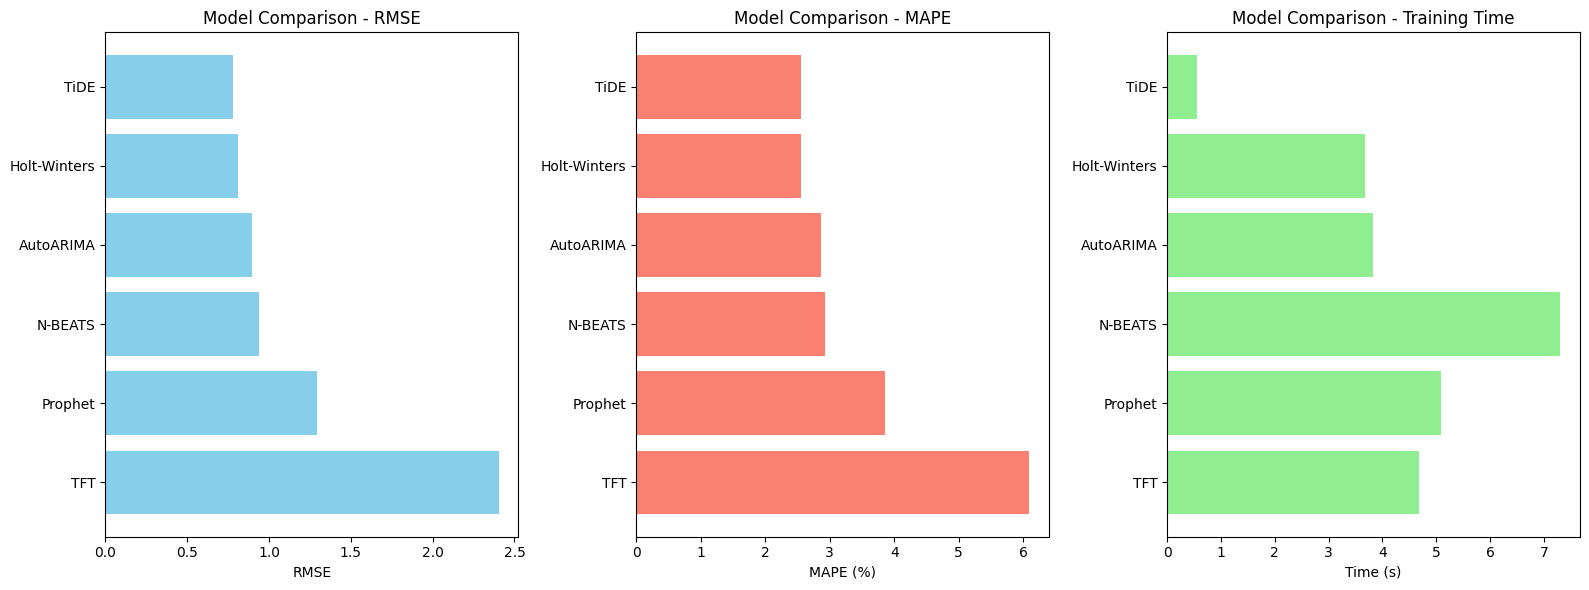

In [9]:
# 8. Compare Results

results_df = get_results_df()
print(results_df)

# Plot comparison with multiple metrics (RMSE, MAPE, Time)
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# RMSE comparison
axes[0].barh(results_df['Model'], results_df['RMSE'], color='skyblue')
axes[0].set_xlabel('RMSE')
axes[0].set_title('Model Comparison - RMSE')
axes[0].invert_yaxis()

# MAPE comparison
axes[1].barh(results_df['Model'], results_df['MAPE'], color='salmon')
axes[1].set_xlabel('MAPE (%)')
axes[1].set_title('Model Comparison - MAPE')
axes[1].invert_yaxis()

# Time comparison
axes[2].barh(results_df['Model'], results_df['Time (s)'], color='lightgreen')
axes[2].set_xlabel('Time (s)')
axes[2].set_title('Model Comparison - Training Time')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 19.8 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 78     | train
--------------------------------------------------------------
61.8 K    Trainable params
0         Non-trainable params
61.8 K    Total params
0.247     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval 

Best RMSE Model: TiDE with params {'input_chunk_length': 12, 'output_chunk_length': 6, 'n_epochs': 10, 'random_state': 42, 'hidden_size': 128, 'dropout': 0.2, 'num_encoder_layers': 1, 'num_decoder_layers': 1}
Fastest Model: TiDE with params {'input_chunk_length': 12, 'output_chunk_length': 6, 'n_epochs': 10, 'random_state': 42, 'hidden_size': 128, 'dropout': 0.2, 'num_encoder_layers': 1, 'num_decoder_layers': 1} (Time: 0.56s)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

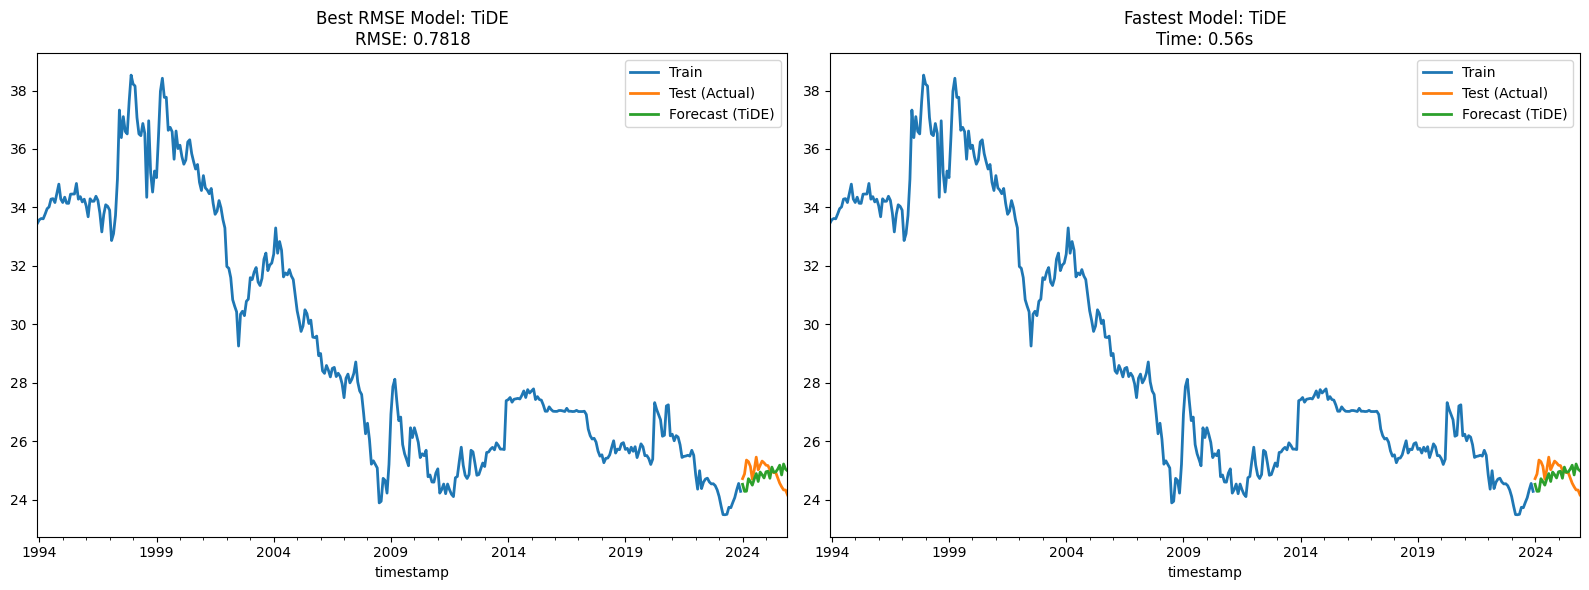

In [10]:
# 9. Final Prediction with Best Model (RMSE) and Fastest Model

def train_and_predict(model_name, params, is_dl):
    """Helper function to train model and get predictions."""
    model_map = {
        "Holt-Winters": ExponentialSmoothing,
        "AutoARIMA": AutoARIMA,
        "Prophet": Prophet,
        "TiDE": TiDEModel,
        "N-BEATS": NBEATSModel,
        "TFT": TFTModel
    }
    
    if model_name not in model_map:
        return None
        
    model_cls = model_map[model_name]
    model = model_cls(**params)
    
    if is_dl:
        model.fit(train_scaled)
        pred_scaled = model.predict(len(test))
        pred = scaler.inverse_transform(pred_scaled)
    else:
        model.fit(train)
        pred = model.predict(len(test))
    
    return pred

if not results_df.empty:
    # Best model by RMSE
    best_rmse_model = results_df.iloc[0]['Model']
    best_rmse_params = results_df.iloc[0]['Params']
    is_dl_rmse = best_rmse_model in ["TiDE", "N-BEATS", "TFT"]
    
    # Fastest model (best time)
    fastest_df = results_df.sort_values(by='Time (s)')
    fastest_model = fastest_df.iloc[0]['Model']
    fastest_params = fastest_df.iloc[0]['Params']
    is_dl_fastest = fastest_model in ["TiDE", "N-BEATS", "TFT"]
    
    print(f"Best RMSE Model: {best_rmse_model} with params {best_rmse_params}")
    print(f"Fastest Model: {fastest_model} with params {fastest_params} (Time: {fastest_df.iloc[0]['Time (s)']:.2f}s)")
    
    # Create predictions
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Best RMSE Model
    pred_rmse = train_and_predict(best_rmse_model, best_rmse_params, is_dl_rmse)
    if pred_rmse is not None:
        train.plot(ax=axes[0], label='Train')
        test.plot(ax=axes[0], label='Test (Actual)')
        pred_rmse.plot(ax=axes[0], label=f'Forecast ({best_rmse_model})')
        axes[0].set_title(f'Best RMSE Model: {best_rmse_model}\nRMSE: {results_df.iloc[0]["RMSE"]:.4f}')
        axes[0].legend()
    else:
        axes[0].text(0.5, 0.5, f'Model {best_rmse_model} not available', ha='center', va='center')
        axes[0].set_title('Best RMSE Model - Not Available')
    
    # Plot 2: Fastest Model
    if fastest_model == best_rmse_model:
        # Same model, just copy the prediction
        pred_fast = pred_rmse
    else:
        pred_fast = train_and_predict(fastest_model, fastest_params, is_dl_fastest)
    
    if pred_fast is not None:
        train.plot(ax=axes[1], label='Train')
        test.plot(ax=axes[1], label='Test (Actual)')
        pred_fast.plot(ax=axes[1], label=f'Forecast ({fastest_model})')
        axes[1].set_title(f'Fastest Model: {fastest_model}\nTime: {fastest_df.iloc[0]["Time (s)"]:.2f}s')
        axes[1].legend()
    else:
        axes[1].text(0.5, 0.5, f'Model {fastest_model} not available', ha='center', va='center')
        axes[1].set_title('Fastest Model - Not Available')
    
    plt.tight_layout()
    plt.show()
else:
    print("No results to display.")